## Loading the Data

In [19]:
!pip install kaggle

In [20]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kinguistics/heartbeat-sounds


mkdir: cannot create directory ‘/root/.kaggle’: File exists
 95% 105M/110M [00:01<00:00, 99.3MB/s] 
100% 110M/110M [00:01<00:00, 89.7MB/s]


In [21]:
!unzip heartbeat-sounds.zip

Archive:  heartbeat-sounds.zip
  inflating: set_a.csv               
  inflating: set_a/Aunlabelledtest__201012172010.wav  
  inflating: set_a/Aunlabelledtest__201101051105.wav  
  inflating: set_a/Aunlabelledtest__201101061552.wav  
  inflating: set_a/Aunlabelledtest__201101091156.wav  
  inflating: set_a/Aunlabelledtest__201101110659.wav  
  inflating: set_a/Aunlabelledtest__201101152256.wav  
  inflating: set_a/Aunlabelledtest__201101220549.wav  
  inflating: set_a/Aunlabelledtest__201101241434.wav  
  inflating: set_a/Aunlabelledtest__201102081033.wav  
  inflating: set_a/Aunlabelledtest__201102081045.wav  
  inflating: set_a/Aunlabelledtest__201102200848.wav  
  inflating: set_a/Aunlabelledtest__201103011036.wav  
  inflating: set_a/Aunlabelledtest__201103140236.wav  
  inflating: set_a/Aunlabelledtest__201103170122.wav  
  inflating: set_a/Aunlabelledtest__201103200518.wav  
  inflating: set_a/Aunlabelledtest__201103201314.wav  
  inflating: set_a/Aunlabelledtest__201103232251.wa

In [46]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import librosa
import os
import fnmatch
from sklearn import metrics

In [23]:
df_a = pd.read_csv('set_a.csv')
df_a.head()

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN


## Preprocessing and Feature Extraction

In [24]:
df_a_timing = pd.read_csv('set_a_timing.csv')
df_b = pd.read_csv('set_b.csv')

In [25]:
df = pd.concat([df_a, df_b])
df.describe()

,dataset,fname,label,sublabel
count,832,832,585,149
unique,2,832,5,2
top,b,set_a/artifact__201012172012.wav,normal,noisynormal
freq,656,1,351,120


In [26]:
print(df.label.unique())

['artifact' 'extrahls' 'murmur' 'normal' nan 'extrastole']


In [27]:
print(df.shape)

(832, 4)


In [28]:
def normalize(y):
  ymin, ymax = np.min(y), np.max(y)
  y = (y - ymin)/(ymax - ymin)
  return y - 0.5

In [29]:
def load_audio_data(path_to_folder, file_names, duration=5, sample_rate=16000):
  input_len = duration*sample_rate
  data = []
  for file_name in file_names:
    y, sr = librosa.load(path_to_folder + file_name, res_type='kaiser_fast')
    file_dur = librosa.get_duration(y=y, sr=sr)
    if (file_dur < duration):
      y = librosa.util.fix_length(y, input_len)
    y = normalize(y)
    mfccs = np.mean(librosa.feature.mfcc(y=y,sr=sr,n_mfcc=40).T, axis=0)
    feature = np.array(mfccs).reshape([-1,1])
    data.append(feature)
  return data


In [30]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

classes = [x for x in df.label.unique() if pd.notnull(x)]

In [31]:
print(classes)

['artifact', 'extrahls', 'murmur', 'normal', 'extrastole']


In [32]:
PATH_TO_A='/content/set_a/'
MAX_DURATION = 5
# set-a
A_artifact_files = fnmatch.filter(os.listdir('/content/set_a'), 'artifact*.wav')
A_artifact_sounds = load_audio_data(path_to_folder=PATH_TO_A,file_names=A_artifact_files, duration=MAX_DURATION)
A_artifact_labels = [0 for items in A_artifact_files]

A_extrahls_files = fnmatch.filter(os.listdir('/content/set_a'), 'extrahls*.wav')
A_extrahls_sounds = load_audio_data(path_to_folder=PATH_TO_A,file_names=A_extrahls_files, duration=MAX_DURATION)
A_extrahls_labels = [1 for items in A_extrahls_sounds]

A_murmur_files = fnmatch.filter(os.listdir('/content/set_a'), 'murmur*.wav')
A_murmur_sounds = load_audio_data(path_to_folder=PATH_TO_A,file_names=A_murmur_files, duration=MAX_DURATION)
A_murmur_labels = [2 for items in A_murmur_files]

A_normal_files = fnmatch.filter(os.listdir('/content/set_a'), 'normal*.wav')
A_normal_sounds = load_audio_data(path_to_folder=PATH_TO_A,file_names=A_normal_files, duration=MAX_DURATION)
A_normal_labels = [3 for items in A_normal_sounds]

A_extrastole_files = fnmatch.filter(os.listdir('/content/set_a'), 'normal*.wav')
A_extrastole_sounds = load_audio_data(path_to_folder=PATH_TO_A,file_names=A_extrastole_files, duration=MAX_DURATION)
A_extrastole_labels = [4 for items in A_extrastole_sounds]

print ("loaded dataset-a")

loaded dataset-a


In [33]:
PATH_TO_B='/content/set_b/'
# set-b
B_artifact_files = fnmatch.filter(os.listdir('/content/set_b'), 'artifact*.wav')
B_artifact_sounds = load_audio_data(path_to_folder=PATH_TO_B,file_names=B_artifact_files, duration=MAX_DURATION)
B_artifact_labels = [0 for items in B_artifact_files]

B_extrahls_files = fnmatch.filter(os.listdir('/content/set_b'), 'extrahls*.wav')
B_extrahls_sounds = load_audio_data(path_to_folder=PATH_TO_B,file_names=B_extrahls_files, duration=MAX_DURATION)
B_extrahls_labels = [1 for items in B_extrahls_sounds]

B_murmur_files = fnmatch.filter(os.listdir('/content/set_b'), 'murmur*.wav')
B_murmur_sounds = load_audio_data(path_to_folder=PATH_TO_B,file_names=B_murmur_files, duration=MAX_DURATION)
B_murmur_labels = [2 for items in B_murmur_files]

B_normal_files = fnmatch.filter(os.listdir('/content/set_b'), 'normal*.wav')
B_normal_sounds = load_audio_data(path_to_folder=PATH_TO_B,file_names=B_normal_files, duration=MAX_DURATION)
B_normal_labels = [3 for items in B_normal_sounds]

B_extrastole_files = fnmatch.filter(os.listdir('/content/set_b'), 'normal*.wav')
B_extrastole_sounds = load_audio_data(path_to_folder=PATH_TO_B,file_names=B_extrastole_files, duration=MAX_DURATION)
B_extrastole_labels = [4 for items in B_extrastole_sounds]

print ("loaded dataset-b")

loaded dataset-b


In [34]:
print(np.array(A_artifact_sounds).shape)
print(np.array(A_normal_sounds).shape)
print(np.array(A_extrahls_sounds).shape)
print(np.array(A_murmur_sounds).shape)
print(np.array(A_extrastole_sounds).shape)
print(np.array(B_artifact_sounds).shape)
print(np.array(B_normal_sounds).shape)
print(np.array(B_extrahls_sounds).shape)
print(np.array(B_murmur_sounds).shape)
print(np.array(B_extrastole_sounds).shape)

(40, 40, 1)
(31, 40, 1)
(19, 40, 1)
(34, 40, 1)
(31, 40, 1)
(0,)
(320, 40, 1)
(0,)
(95, 40, 1)
(320, 40, 1)


In [35]:
print(np.array(A_artifact_labels).shape)
print(np.array(A_normal_labels).shape)
print(np.array(A_extrahls_labels).shape)
print(np.array(A_murmur_labels).shape)
print(np.array(A_extrastole_labels).shape)
print(np.array(B_artifact_labels).shape)
print(np.array(B_normal_labels).shape)
print(np.array(B_extrahls_labels).shape)
print(np.array(B_murmur_labels).shape)
print(np.array(B_extrastole_labels).shape)

(40,)
(31,)
(19,)
(34,)
(31,)
(0,)
(320,)
(0,)
(95,)
(320,)


B_extrahls and B_artifact are empty

In [36]:
x_data = np.concatenate((
    A_artifact_sounds,
    A_normal_sounds,
    A_extrahls_sounds,
    A_murmur_sounds,
    A_extrastole_sounds,
    B_normal_sounds,
    B_murmur_sounds,
    B_extrastole_sounds
    ))


In [37]:
y_data = np.concatenate((
    A_artifact_labels,
    A_normal_labels,
    A_extrahls_labels,
    A_murmur_labels,
    A_extrastole_labels,
    B_normal_labels,
    B_murmur_labels,
    B_extrastole_labels,
    ))

In [38]:
print(x_data.shape, y_data.shape)

(890, 40, 1) (890,)


In [39]:
x_data = np.reshape(x_data, (890, 40))

In [40]:
seed = 42
# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.9, random_state=seed, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.9, random_state=seed, shuffle=True)

# One-Hot encoding for classes
classes_count = len(classes)
y_train = np.eye(classes_count)[y_train]
y_test = np.eye(classes_count)[y_test]
y_val = np.eye(classes_count)[y_val]

In [41]:
print ("label shape: ", y_data.shape)
print ("data size of the array: : %s" % y_data.size)
print ("length of one array element in bytes: ", y_data.itemsize)
print ("total bytes consumed by the elements of the array: ", y_data.nbytes)
print (y_data[1])
print ("")
print ("audio data shape: ", x_data.shape)
print ("data size of the array: : %s" % x_data.size)
print ("length of one array element in bytes: ", x_data.itemsize)
print ("total bytes consumed by the elements of the array: ", x_data.nbytes)
#print (x_data[1])
print ("")
print ("training data shape: ", x_train.shape)
print ("training label shape: ", y_train.shape)
print ("")
print ("validation data shape: ", x_val.shape)
print ("validation label shape: ", y_val.shape)
print ("")

label shape:  (890,)
data size of the array: : 890
length of one array element in bytes:  8
total bytes consumed by the elements of the array:  7120
0

audio data shape:  (890, 40)
data size of the array: : 35600
length of one array element in bytes:  4
total bytes consumed by the elements of the array:  142400

training data shape:  (720, 40)
training label shape:  (720, 5)

validation data shape:  (81, 40)
validation label shape:  (81, 5)



In [42]:
def to_label(onehot_arr):
  return np.array([list(ele).index(1) for ele in onehot_arr])

Now that we have our features and labels in a model-friendly format, we are free to apply any ML model we deem applicable:

## Simple Classifiers

In [43]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

clf = RandomForestClassifier()
clf.fit(x_train, to_label(y_train))
pred = clf.predict(x_val)

In [44]:
pred_proba = clf.predict_proba(x_val)

In [47]:
metrics.log_loss(y_val, pred_proba)

1.6665165302230807

In [48]:
metrics.log_loss(y_test, clf.predict_proba(x_test))

1.6530961406736706

In [49]:
to_label(y_val).shape

(81,)

In [55]:
def get_spectrogram(path_to_folder, file_name, duration=5, sample_rate=16000):
  input_len = duration*sample_rate

  y, sr = librosa.load(path_to_folder + file_name, res_type='kaiser_fast')
  file_dur = librosa.get_duration(y=y, sr=sr)
  S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
  S_dB = librosa.power_to_db(S, ref=np.max)
  return S_dB

In [50]:
import librosa.display

def plot_spectrogram(path_to_folder, file_name, duration=5, sample_rate=16000):
  input_len = duration*sample_rate

  y, sr = librosa.load(path_to_folder + file_name, res_type='kaiser_fast')
  file_dur = librosa.get_duration(y=y, sr=sr)
  S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
  fig, ax = plt.subplots()
  S_dB = librosa.power_to_db(S, ref=np.max)
  img = librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=sr,
                          fmax=8000, ax=ax)
  fig.colorbar(img, ax=ax, format='%+2.0f dB')
  ax.set(title='Mel-frequency spectrogram - Extra Heart Sound')


In [51]:
df.label.unique()

array(['artifact', 'extrahls', 'murmur', 'normal', nan, 'extrastole'],
      dtype=object)

In [52]:
df[df.label == 'extrahls'].head()

,dataset,fname,label,sublabel
40,a,set_a/extrahls__201101070953.wav,extrahls,NaN
41,a,set_a/extrahls__201101091153.wav,extrahls,NaN
42,a,set_a/extrahls__201101152255.wav,extrahls,NaN
43,a,set_a/extrahls__201101160804.wav,extrahls,NaN
44,a,set_a/extrahls__201101160808.wav,extrahls,NaN


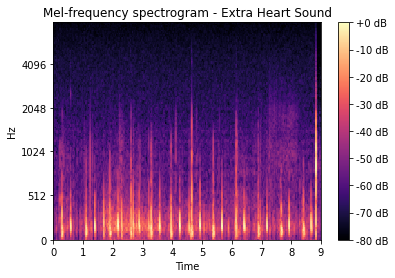

In [53]:
plot_spectrogram('/content/set_a/', 'extrahls__201101241433.wav')

## LSTM Model

In [72]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.layers import Convolution2D, MaxPooling2D
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from keras.utils import np_utils
from tensorflow.keras.optimizers import Adam
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import itertools

In [76]:
print('Build LSTM RNN model ...')
model = Sequential()
model.add(LSTM(units=32, dropout=0.05, recurrent_dropout=0.20, return_sequences=True,input_shape = (40,1)))
model.add(LSTM(units=24, dropout=0.05, recurrent_dropout=0.20, return_sequences=False))
model.add(Dense(len(classes), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adamax', metrics=['acc','mse', 'mae', 'mape'])
model.summary()

Build LSTM RNN model ...
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 40, 32)            4352      
                                                                 
 lstm_9 (LSTM)               (None, 24)                5472      
                                                                 
 dense_15 (Dense)            (None, 5)                 125       
                                                                 
Total params: 9,949
Trainable params: 9,949
Non-trainable params: 0
_________________________________________________________________


In [77]:
%%time
best_model_file="./best_model.hdf5"
MAX_PATIENT=8
MAX_EPOCHS=100
MAX_BATCH=32

callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]

history=model.fit(x_train, y_train, 
                  batch_size=MAX_BATCH, 
                  epochs=MAX_EPOCHS,
                  verbose=0,
                  validation_data=(x_val, y_val),
                  callbacks=callback) 

print ("done!")



Epoch 1: loss improved from inf to 1.43893, saving model to ./best_model.hdf5

Epoch 2: loss improved from 1.43893 to 1.27333, saving model to ./best_model.hdf5

Epoch 3: loss improved from 1.27333 to 1.22449, saving model to ./best_model.hdf5

Epoch 4: loss improved from 1.22449 to 1.20717, saving model to ./best_model.hdf5

Epoch 5: loss improved from 1.20717 to 1.19531, saving model to ./best_model.hdf5

Epoch 6: loss improved from 1.19531 to 1.18854, saving model to ./best_model.hdf5

Epoch 7: loss improved from 1.18854 to 1.18184, saving model to ./best_model.hdf5

Epoch 8: loss improved from 1.18184 to 1.17966, saving model to ./best_model.hdf5

Epoch 9: loss improved from 1.17966 to 1.17402, saving model to ./best_model.hdf5

Epoch 10: loss improved from 1.17402 to 1.16901, saving model to ./best_model.hdf5

Epoch 11: loss improved from 1.16901 to 1.16242, saving model to ./best_model.hdf5

Epoch 12: loss improved from 1.16242 to 1.15658, saving model to ./best_model.hdf5

Epoc

<Figure size 1584x720 with 0 Axes>

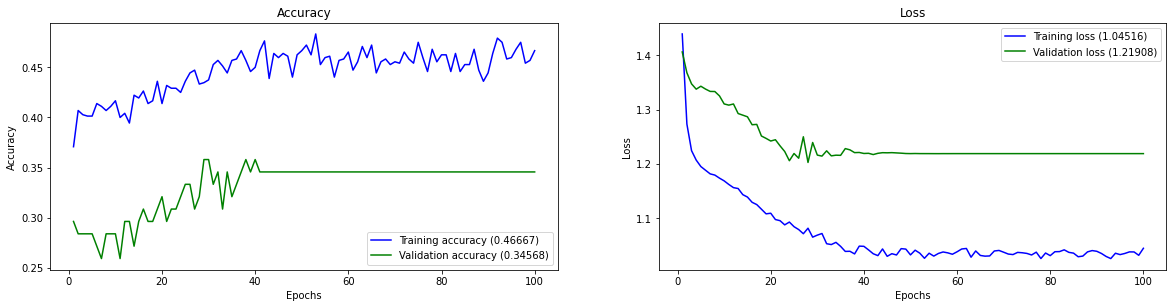

In [79]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    plt.figure(figsize=(22,10))
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    ## Accuracy
    plt.figure(221, figsize=(20,10))
    ## Accuracy
    # plt.figure(2,figsize=(14,5))
    plt.subplot(221, title='Accuracy')
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    ## Loss
    plt.subplot(222, title='Loss')
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# plot history
plot_history(history)

In [80]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

array([[0.00249144, 0.00204115, 0.08975889, 0.42857608, 0.4771324 ],
       [0.00389506, 0.00246163, 0.11581539, 0.41800147, 0.45982647],
       [0.47367376, 0.12647757, 0.12152869, 0.1611792 , 0.11714075],
       [0.00228219, 0.00193513, 0.08763788, 0.4283236 , 0.47982123],
       [0.0030761 , 0.00182382, 0.09779473, 0.42516348, 0.4721419 ],
       [0.00219855, 0.00241294, 0.09019894, 0.43349722, 0.4716924 ],
       [0.00611644, 0.00228667, 0.09277531, 0.42215008, 0.4766715 ],
       [0.00644828, 0.00201861, 0.09876809, 0.422665  , 0.47010005],
       [0.00235515, 0.0026936 , 0.09640224, 0.43407682, 0.46447212],
       [0.00225188, 0.00234657, 0.08995237, 0.43393582, 0.47151333],
       [0.00247799, 0.00352721, 0.11273988, 0.4271701 , 0.45408478],
       [0.00210813, 0.00260003, 0.0926659 , 0.426838  , 0.47578797],
       [0.00357832, 0.00441774, 0.15431847, 0.39925987, 0.43842563],
       [0.01633287, 0.01516032, 0.22960654, 0.357241  , 0.38165918],
       [0.00290823, 0.00243801, 0.

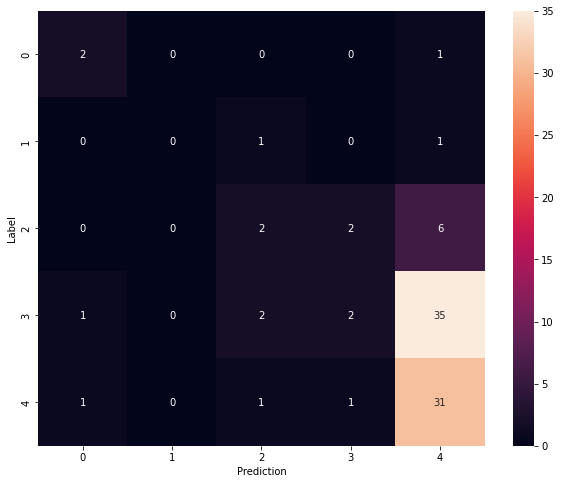

In [98]:
y_pred = np.argmax(model.predict(x_test, batch_size=32), axis=-1)
confusion_mtx = tf.math.confusion_matrix(to_label(y_test), y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()
